In [1]:
!pip install pyaurn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 364 kB 14.8 MB/s 


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import requests
import pyaurn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]
import os

from concurrent.futures import ThreadPoolExecutor, wait
from google.colab import drive
from shutil import make_archive, move
from math import sin, cos

In [3]:
metadata = pyaurn.importMeta().set_index("site_id")

In [61]:
display(metadata)
filtered_metadata = metadata.drop(["site_name", "location_type", "parameter", "Parameter_name", "start_date", "end_date", "ratified_to", "zone", "agglomeration", "local_authority"], axis=1)

,site_name,location_type,latitude,longitude,parameter,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
site_id,,,,,,,,,,,,
ABD,Aberdeen,Urban Background,57.157360,-2.094278,O3,Ozone,2003-08-01,2021-09-20,2021-09-20,North East Scotland,NaN,Aberdeen City
ABD9,Aberdeen Erroll Park,Urban Background,57.157400,-2.094770,O3,Ozone,2021-10-01,ongoing,2022-06-30,North East Scotland,NaN,Aberdeen City
ABD7,Aberdeen Union Street Roadside,Urban Traffic,57.144555,-2.106472,NO,Nitric oxide,2008-01-01,ongoing,2022-06-30,North East Scotland,NaN,Aberdeen City
ABD8,Aberdeen Wellington Road,Urban Traffic,57.133888,-2.094198,NO,Nitric oxide,2016-02-09,ongoing,2022-06-30,North East Scotland,NaN,Aberdeen City
ARM6,Armagh Roadside,Urban Traffic,54.353728,-6.654558,NO,Nitric oxide,2009-01-01,ongoing,2022-06-30,Northern Ireland,NaN,Armagh
...,...,...,...,...,...,...,...,...,...,...,...,...
WRAY,Wray,Rural Background,54.104666,-2.584182,O3,Ozone,1985-04-01,1988-02-29,1988-02-29,North West & Merseyside,NaN,Lancaster
WREX,Wrexham,Urban Traffic,53.042282,-3.002829,NO,Nitric oxide,2002-03-06,ongoing,2022-06-30,North Wales,NaN,Wrexham
YW,Yarner Wood,Rural Background,50.597600,-3.716510,O3,Ozone,1987-06-26,ongoing,2022-06-30,South West,NaN,Teignbridge


In [62]:
def get_site_data(name, year_range):
  try:
    data = pyaurn.importAURN(name, year_range).reset_index()
    data["site_id"] = name
    data["day"] = data["date"].dt.day
    data["month"] = data["date"].dt.month
    data["year"] = data["date"].dt.year
    data["hour"] = data["date"].dt.hour
    data["minute"] = data["date"].dt.minute
    data["second"] = data["date"].dt.second
    if "PM2.5" in data.columns:
      data = data[["day", "month", "year", "hour", "minute", "second", "PM2.5", "site_id"]]
      data = data.dropna()
      data = data.merge(filtered_metadata, on="site_id").drop("site_id", axis=1)
      return data
  except KeyError:
    return

In [63]:
display(metadata.index)
with ThreadPoolExecutor(min(32, os.cpu_count() + 4)) as executor:
  all_data = [executor.submit(get_site_data, name, range(2021, 2022)) for name in metadata.index]
  all_data = wait(all_data)


Index(['ABD', 'ABD9', 'ABD7', 'ABD8', 'ARM6', 'AH', 'ACTH', 'BAAR', 'BALM',
       'BARN',
       ...
       'WIG5', 'WIG3', 'TRAN', 'WOLV', 'WTHG', 'WRAY', 'WREX', 'YW', 'YK10',
       'YK11'],
      dtype='object', name='site_id', length=278)



























/usr/local/lib/python3.8/dist-packages/pyaurn.py:145: UserWarning: Some data files were not able to be downloaded, check resulting DataFrame carefully
  warnings.warn('Some data files were not able to be downloaded, check resulting DataFrame carefully')
/usr/local/lib/python3.8/dist-packages/pyaurn.py:147: UserWarning: Resulting DataFrame is empty
  warnings.warn('Resulting DataFrame is empty')


































































































































































































































































































































































































































































































































































































In [64]:
retrieved_data = [item.result() for item in all_data.done]
display(retrieved_data[0])
concatenated_data = pd.concat(retrieved_data, ignore_index=True)
display(concatenated_data)

None

,day,month,year,hour,minute,second,PM2.5,latitude,longitude
0,1,10,2021,1,0,0,2.830,57.157400,-2.094770
1,1,10,2021,2,0,0,2.995,57.157400,-2.094770
2,1,10,2021,3,0,0,3.561,57.157400,-2.094770
3,1,10,2021,4,0,0,3.679,57.157400,-2.094770
4,1,10,2021,5,0,0,4.316,57.157400,-2.094770
...,...,...,...,...,...,...,...,...,...
656745,31,12,2021,19,0,0,8.844,51.149617,-1.438228
656746,31,12,2021,20,0,0,7.146,51.149617,-1.438228
656747,31,12,2021,21,0,0,8.467,51.149617,-1.438228
656748,31,12,2021,22,0,0,8.326,51.149617,-1.438228


In [65]:
dataset_length = len(concatenated_data)

#train_dataset = concatenated_data[0:int(0.7*dataset_length)]
#val_dataset = concatenated_data[int(0.7*dataset_length):int(0.9*dataset_length)]
#test_dataset = concatenated_data[int(0.9*dataset_length):]

train_dataset = concatenated_data.sample(frac=0.7)
val_dataset = concatenated_data.drop(train_dataset.index).sample(frac=0.66)
test_dataset = concatenated_data.drop(train_dataset.index).drop(val_dataset.index)
display(train_dataset)
display(val_dataset)
display(test_dataset)

,day,month,year,hour,minute,second,PM2.5,latitude,longitude
101137,15,8,2021,9,0,0,4.387,54.439510,-7.900328
423723,10,4,2021,10,0,0,3.000,54.978250,-1.610528
150558,5,5,2021,15,0,0,1.651,52.288810,-1.533119
214386,9,4,2021,14,0,0,1.958,53.803780,-1.546472
393254,9,3,2021,5,0,0,9.882,53.372870,-3.022722
...,...,...,...,...,...,...,...,...,...
257992,6,6,2021,4,0,0,2.288,55.865782,-4.243631
577186,17,11,2021,5,0,0,9.032,52.272257,-0.916605
275790,10,7,2021,16,0,0,8.000,51.583950,-3.770822
479808,13,11,2021,4,0,0,1.887,51.601203,-2.977281


,day,month,year,hour,minute,second,PM2.5,latitude,longitude
652211,24,6,2021,13,0,0,12.925,51.149617,-1.438228
505410,27,3,2021,6,0,0,8.000,51.374264,0.547970
209412,12,9,2021,19,0,0,6.179,52.294884,-1.542911
32028,3,6,2021,17,0,0,9.576,52.954730,-1.146447
238358,27,1,2021,14,0,0,21.000,53.967513,-1.086514
...,...,...,...,...,...,...,...,...,...
495769,30,1,2021,3,0,0,3.800,53.951889,-1.075861
112349,1,12,2021,5,0,0,1.321,54.883610,-1.406878
629604,7,9,2021,0,0,0,10.000,50.411463,-4.227678
415626,3,5,2021,15,0,0,4.953,51.449674,-0.037418


,day,month,year,hour,minute,second,PM2.5,latitude,longitude
5,1,10,2021,6,0,0,3.019,57.157400,-2.094770
18,1,10,2021,19,0,0,2.689,57.157400,-2.094770
36,2,10,2021,13,0,0,7.193,57.157400,-2.094770
37,2,10,2021,14,0,0,7.359,57.157400,-2.094770
46,2,10,2021,23,0,0,3.703,57.157400,-2.094770
...,...,...,...,...,...,...,...,...,...
656642,27,12,2021,12,0,0,8.656,51.149617,-1.438228
656668,28,12,2021,14,0,0,2.382,51.149617,-1.438228
656697,29,12,2021,19,0,0,11.226,51.149617,-1.438228
656717,30,12,2021,15,0,0,4.528,51.149617,-1.438228


In [53]:
def df_to_dataset(dataframe, target, shuffle=False, batch_size=32):
  df = dataframe.copy()
  labels = df.pop(target)
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [57]:
train_tf_dataset = df_to_dataset(train_dataset, "PM2.5")
val_tf_dataset = df_to_dataset(val_dataset, "PM2.5")
test_tf_dataset = df_to_dataset(test_dataset, "PM2.5")
for i in train_tf_dataset.take(1):
  print(i)

({'day': <tf.Tensor: shape=(32, 1), dtype=int64, numpy=
array([[ 1],
       [ 2],
       [ 6],
       [19],
       [ 5],
       [13],
       [17],
       [18],
       [17],
       [17],
       [28],
       [ 5],
       [27],
       [16],
       [21],
       [22],
       [15],
       [ 2],
       [22],
       [19],
       [25],
       [16],
       [31],
       [11],
       [ 6],
       [13],
       [24],
       [10],
       [ 4],
       [21],
       [11],
       [ 3]])>, 'month': <tf.Tensor: shape=(32, 1), dtype=int64, numpy=
array([[ 6],
       [ 6],
       [10],
       [ 4],
       [ 3],
       [12],
       [ 4],
       [ 8],
       [ 7],
       [ 5],
       [ 9],
       [12],
       [ 2],
       [10],
       [ 2],
       [ 1],
       [ 7],
       [ 6],
       [ 7],
       [ 1],
       [ 2],
       [ 3],
       [ 8],
       [ 6],
       [11],
       [ 8],
       [ 4],
       [12],
       [ 9],
       [ 2],
       [ 2],
       [ 3]])>, 'year': <tf.Tensor: shape=(32, 1), dtype=int64, nu

<ipython-input-53-b2f8b73061b8>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [66]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("PM2.5")
val_labels = val_features.pop("PM2.5")
test_labels = test_features.pop("PM2.5")

train_features.shape

(459725, 8)

In [43]:
def split_data_for_preprocessing(dataset):
  text_cols = ["location_type", "zone"]
  number_cols = ["day", "month", "year", "hour", "minute", "second", "latitude", "longitude"]

  return (dataset[number_cols], dataset[text_cols])

In [56]:
train_features_split = split_data_for_preprocessing(train_features)
val_features_split = split_data_for_preprocessing(val_features)
test_features_split = split_data_for_preprocessing(test_features)

TypeError: ignored

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 8)]               0         
                                                                 
 normalization_15 (Normaliza  (None, 8)                17        
 tion)                                                           
                                                                 
 dense_26 (Dense)            (None, 32)                288       
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 338
Trainable params: 321
Non-trainable params: 17
_________________________________________________________________


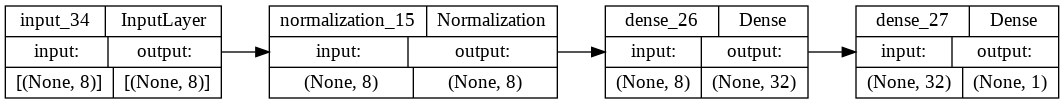

In [84]:
#vocabulary = np.append(pd.unique(train_features["location_type"]), pd.unique(train_features["zone"]))
#category_input = tf.keras.layers.Input(shape=(2,))
#lookup_layer = tf.keras.layers.StringLookup(vocabulary=vocabulary)(category_input)
#encoder_layer = tf.keras.layers.CategoryEncoding(num_tokens=len(vocabulary))(lookup_layer)

inputs = tf.keras.layers.Input(shape=(8,))
normalisation_layer = tf.keras.layers.Normalization()
normalisation_layer.adapt(train_features)
normalisation_layer = normalisation_layer(inputs)

#inputs = tf.keras.layers.concatenate([encoder_layer, normalisation_layer])
dense_layer = tf.keras.layers.Dense(32, activation="tanh")(normalisation_layer)
outputs = tf.keras.layers.Dense(1)(dense_layer)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [85]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
    metrics = ["mean_absolute_error"]
)

In [86]:
print(train_features.dtypes)
history = model.fit(
    train_features,
    train_labels,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.001),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

    ],
    validation_data = (val_features, val_labels)
)

day            int64
month          int64
year           int64
hour           int64
minute         int64
second         int64
latitude     float64
longitude    float64
dtype: object
Epoch 1/10
14367/14367 [==============================] - 23s 2ms/step - loss: 39.6898 - mean_absolute_error: 4.2988 - val_loss: 37.4254 - val_mean_absolute_error: 4.0502 - lr: 0.1000
Epoch 2/10
14367/14367 [==============================] - 21s 1ms/step - loss: 37.3144 - mean_absolute_error: 4.1749 - val_loss: 35.8045 - val_mean_absolute_error: 4.0023 - lr: 0.1000
Epoch 3/10
14367/14367 [==============================] - 21s 1ms/step - loss: 36.3101 - mean_absolute_error: 4.1153 - val_loss: 37.1733 - val_mean_absolute_error: 4.1144 - lr: 0.1000
Epoch 4/10
14367/14367 [==============================] - 21s 1ms/step - loss: 33.3235 - mean_absolute_error: 3.9155 - val_loss: 33.3942 - val_mean_absolute_error: 3.8304 - lr: 0.0200
Epoch 5/10
14367/14367 [==============================] - 21s 1ms/step - loss: 33.

{'loss': [39.689788818359375,
  37.31436538696289,
  36.31011962890625,
  33.32347869873047,
  33.244686126708984,
  33.15578079223633,
  32.562259674072266,
  32.48008728027344,
  32.46337890625,
  32.3695068359375],
 'mean_absolute_error': [4.298847675323486,
  4.174943923950195,
  4.115306854248047,
  3.915531635284424,
  3.9104831218719482,
  3.9065425395965576,
  3.8583319187164307,
  3.853262186050415,
  3.8531439304351807,
  3.845695734024048],
 'val_loss': [37.42544174194336,
  35.804473876953125,
  37.17325210571289,
  33.39419174194336,
  33.1137580871582,
  33.33781433105469,
  32.58900451660156,
  32.50837326049805,
  32.54689407348633,
  32.45236587524414],
 'val_mean_absolute_error': [4.050170421600342,
  4.002286911010742,
  4.114431381225586,
  3.830350637435913,
  3.9151909351348877,
  3.8785006999969482,
  3.865750312805176,
  3.8434057235717773,
  3.861675500869751,
  3.8435280323028564],
 'lr': [0.1,
  0.1,
  0.1,
  0.02,
  0.02,
  0.02,
  0.0039999997,
  0.00399999

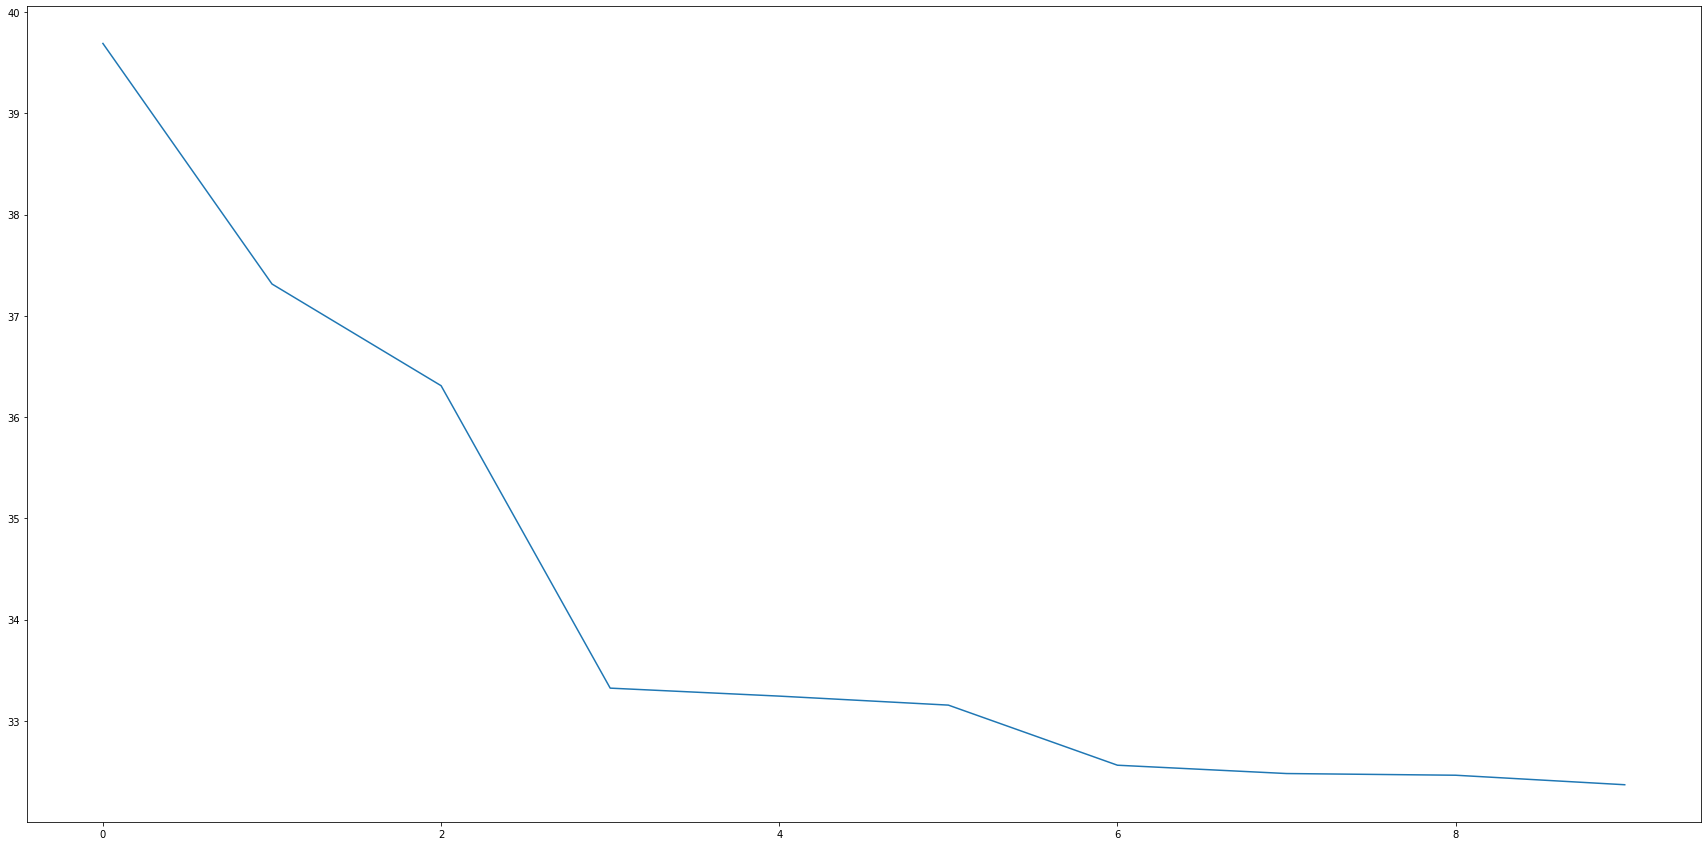

In [87]:
display(history.history)
plt.plot(history.history["loss"])
plt.show()

2094/2094 [==============================] - 2s 958us/step


array([2.7910204, 3.6345372, 2.545556 , ..., 6.409269 , 4.9372864,
       4.9372687], dtype=float32)

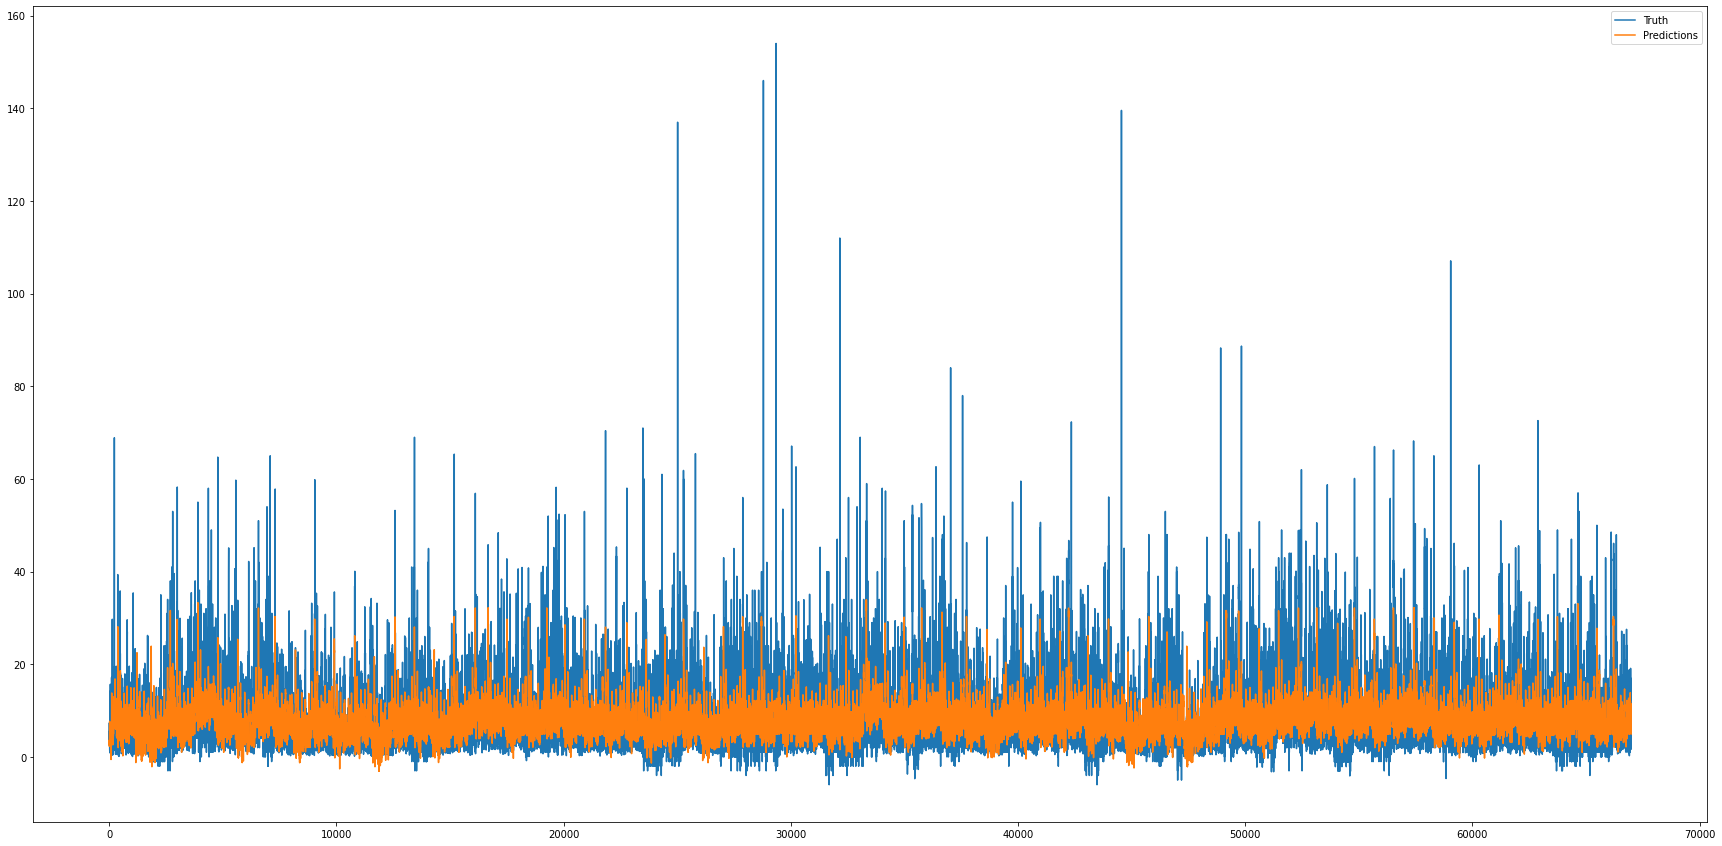

In [88]:
predictions = model.predict(test_features).flatten()
display(predictions)
plt.plot(test_labels.reset_index(drop=True), label="Truth")
plt.plot(predictions, label="Predictions")
plt.legend()

In [ ]:
#drive.mount("/content/gdrive", force_remount=True)
model.save("/content/comp3000model")
zip_location = make_archive("model", "zip", "/content/comp3000model")
#move(zip_location, "/content/gdrive/MyDrive/comp3000model/model.zip")
#drive.flush_and_unmount()